<a href="https://colab.research.google.com/github/sahoopuspanjali/Multivariate_SeqToSeq/blob/master/Submission/VAR_Model/MultivariateSequence_VAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.tsa.vector_ar.var_model import VAR

Read the input file and modify it to put in structred format

In [2]:
#Read the input file in google colab
from google.colab import files
uploaded = files.upload()
#cookies should not be blocked for this

Saving ts_test_43.csv to ts_test_43.csv


In [0]:
# Modify the CSV file to get proper data in sequence
text = open("ts_test_43.csv", "r")
text = ''.join([i for i in text]) \
    .replace(",", ".")\
    .replace(";",",")
x = open("input.csv","w")
x.writelines(text)
x.close()

In [4]:
# put the data in dataframe
df = pd.read_csv('input.csv')
df.head()

,Index,Val_1,Val_2,Val_3
0,1,26.950,10.771,22.770
1,2,46.662,10.195,22.660
2,3,30.470,12.611,13.530
3,4,24.794,14.682,18.249
4,5,35.849,14.277,23.727


Visualize the data

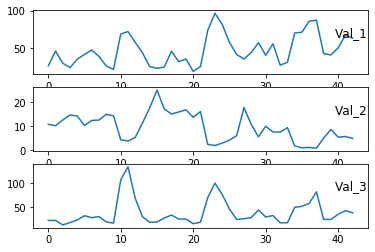

In [5]:
values = df.values
# specify columns to plot
groups = [1, 2, 3]
i = 1
# plot each column
plt.figure()
for group in groups:
	plt.subplot(len(groups), 1, i)
	plt.plot(values[:, group])
	plt.title(df.columns[group], y=0.5, loc='right')
	i += 1
plt.show()

In [6]:
df.dtypes

Index      int64
Val_1    float64
Val_2    float64
Val_3    float64
dtype: object

In [7]:
df['Index'] = pd.to_datetime(df.Index , format = '%S')
data = df.drop(['Index'], axis=1)
data.index = df.Index
data.head()

,Val_1,Val_2,Val_3
Index,,,
1900-01-01 00:00:01,26.950,10.771,22.770
1900-01-01 00:00:02,46.662,10.195,22.660
1900-01-01 00:00:03,30.470,12.611,13.530
1900-01-01 00:00:04,24.794,14.682,18.249
1900-01-01 00:00:05,35.849,14.277,23.727


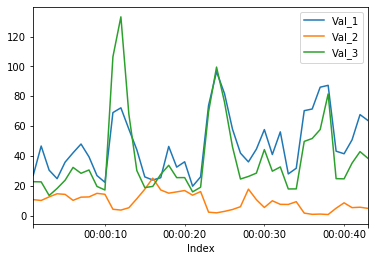

In [8]:
data.plot()
plt.show()

In [9]:
data.dtypes

Val_1    float64
Val_2    float64
Val_3    float64
dtype: object

Stationarity Check

In [10]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

#Randomly droping a variable to check the stationarity
johan_test_temp = data.drop([ 'Val_2'], axis=1)
#bet val1 & val3
print("eig val1 and val3",coint_johansen(johan_test_temp,-1,1).eig)
#print("cvt",coint_johansen(johan_test_temp,-1,1).cvt)
#print("lr1",coint_johansen(johan_test_temp,-1,1).lr1)

eig val1 and val3 [0.32576698 0.01467455]


Multivariate Time Series with VAR Model

In [11]:
#Creating tarining and validation set to train and test the performance of the model
X_train = data[:int(0.8*(len(data)))]
X_valid = data[int(0.8*(len(data))):]
print(X_train.shape, X_valid.shape)


(34, 3) (9, 3)


In [12]:
#fit the model with training data 
model = VAR(endog=X_train)
model_fit = model.fit()
model_pred = model_fit.forecast(model_fit.y, steps=len(X_valid))

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency S will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/wrapper.py:35: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


To Measure the success of the model, MAE and MAPE methods are considered (comparing prediction vs actual data for validation dataset)

In [13]:
from sklearn.metrics import mean_absolute_error 
cols = ['Val_1','Val_2','Val_3']
for i in range(0,len(cols)):
    print('Mean absolute error value for',cols[i], 'is : ', mean_absolute_error(X_valid.to_numpy()[:,i],model_pred[:,i]))

Mean absolute error value for Val_1 is :  23.050967331824346
Mean absolute error value for Val_2 is :  7.614136535482272
Mean absolute error value for Val_3 is :  16.379802439965594


In [14]:
#MAPE : Mean absolute Percentage error

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred =  np.array(y_true), np.array(y_pred)
    return np.mean((np.abs(y_true - y_pred) / np.abs(y_true))* 100)

for i in range(0,len(cols)):
  print('Mean absolute Percentage error value for',cols[i], 'is : ', mean_absolute_percentage_error(X_valid.to_numpy()[:,i],model_pred[:,i]))

Mean absolute Percentage error value for Val_1 is :  31.176561661530894
Mean absolute Percentage error value for Val_2 is :  509.40780401109856
Mean absolute Percentage error value for Val_3 is :  33.382558425451506


Fit the model with full set and predict the for next 4 time step

In [15]:
#fit the model with all the data and predict the values for next 4 sequences for each variable
model = VAR(endog=data)
model_fit = model.fit()
model_Prediction = model_fit.forecast(model_fit.y, steps=4)
model_Prediction = np.round(model_Prediction, 3)
print(model_Prediction)

[[57.108  6.126 36.897]
 [54.241  7.096 37.119]
 [52.522  7.767 37.546]
 [51.403  8.219 37.947]]


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency S will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/wrapper.py:35: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


Write the predicted values to the output.csv file

In [0]:
#generate value for index column
index_no =[]
for i in range(0, len(model_Prediction)):
    index_no.append(len(data)+i+1)

#write the values to "output.csv" file
np.savetxt("output.csv", model_Prediction, delimiter=",", fmt='%1.3f')

#add column names and index values
df = pd.read_csv('output.csv', header=None)
df.rename(columns={0: 'Val_1', 1: 'Val_2', 2: 'Val_3'}, inplace=True)
df.insert(0,"Index",index_no,True)
df.to_csv('output.csv', index=False)


In [0]:
text = open("output.csv", "r")
text = ''.join([i for i in text]) \
    .replace(",", ";")\
    .replace(".",",")
x = open("FormatedOutput.csv","w")
x.writelines(text)
x.close()

In [18]:
!nvidia-smi

Sun Dec  1 23:19:01 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  